<a href="https://colab.research.google.com/github/kai-v/ImageMorphing/blob/main/ImageMorphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms
import PIL as pl
from PIL import Image
import cv2
from io import StringIO
import pandas as pd

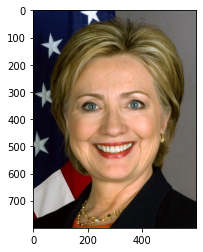

In [269]:
image1 = "/media/hillary_clinton.jpg"
f1 = mp.imread(image1)
plt.imshow(f1)

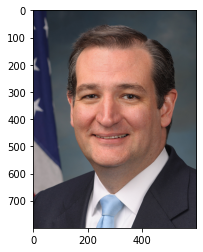

In [270]:
image2 = "/media/ted_cruz.jpg"
f2 = mp.imread(image2)
plt.imshow(f2)

#Initialise the final warped image 
final_image = np.zeros(f1.shape)

Creating the bounding boxes for the traingles 

In [286]:
def boundingBox(triangle):

  box = cv2.boundingRect(np.float32([triangle]))
  
  return box

Increase the size but expanding the corners of the Triangle 

In [285]:
def increaseBoundingBox(triangle,box):

  newTriangle = []

  #Expand the 3 corners of the triangle 
  for i in range(0, 3):
   
    newTriangle.append(((triangle[i][0] - box[0]),(triangle[i][1] - box[1])))

  return newTriangle


Warp triangles

In [287]:
def morph_triangles(alpha, tri1, tri2, tri) :

    #Initialise the Bounding Boxes for the triangles and then increase them 
    rect1 = boundingBox(tri1)
    new_rect1 = increaseBoundingBox(tri1,rect1)

    rect2 = boundingBox(tri2)
    new_rect2 = increaseBoundingBox(tri2,rect2)

    rect = boundingBox(tri)
    new_rect =  increaseBoundingBox(tri,rect)
    
    #Create mask of zeros for pixels outside of the triangles
    mask = np.zeros((rect[3],rect[2],3), dtype = np.float32)

    #Triangular Mask 
    cv2.fillConvexPoly(mask,np.int32(new_rect), (1.0, 1.0, 1.0), 16, 0); 

    # Get smaller rectangualr regions in both the images 
    rect_region1 = f1[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]]
    rect_region2 = f2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]]

    #AFFINE TRANSFORM 
    #Map the three corners of the triangle in an image to corners of the 
    #triangle in the morphed image 

    #Transformation matrix 
    warp_mat1 = cv2.getAffineTransform(np.float32(new_rect1), np.float32(new_rect)) 
    warp_mat2 = cv2.getAffineTransform(np.float32(new_rect2), np.float32(new_rect)) 

    #Warped Image
    dst1 = cv2.warpAffine(rect_region1, warp_mat1,(rect[2], rect[3]), None, 
                          flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 ) 
    
    dst2 = cv2.warpAffine(rect_region2, warp_mat2,(rect[2], rect[3]), None,
                          flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 ) 

    # Alpha blending the two warped images 
    rect_region = (1.0 - alpha) * dst1 + (alpha * dst2)

    region = final_image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]] #rectangular patch
    rectRegion = region * (1 - mask ) + rect_region * mask #Traingular region
    final_image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]] = rectRegion # Copy to the output image


Find location of features in final morphed image 

In [288]:
first = np.loadtxt("/media/hillary_clinton.points.txt")
second = np.loadtxt("/media/ted_cruz.points.txt")

#Change Alpha value here
alpha = 0.5;

final = []

#Locations of the morphed final 
for i in range(0,76):
  
  X = (1 - alpha)*first[i][0] + alpha * second[i][0]
  Y = (1 - alpha)*first[i][1] + alpha * second[i][1]
  final.append((X,Y))

Morph the image triangular regions , with alpha value 

In [282]:
file = open("/media/tri_new_76points.txt")

def morph(alpha):

 for line in file :
  x,y,z = line.split()
            
  x = int(x)
  y = int(y)
  z = int(z)

  tri =  [final[x], final[y], final[z]]       
  tri_1 = [first[x], first[y], first[z]]
  tri_2 = [second[x], second[y], second[z]]
  

  morph_triangles(alpha,tri_1, tri_2, tri)

#print(tri)


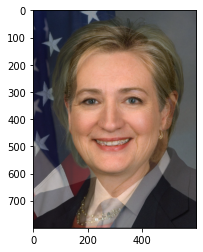

In [289]:
morph(alpha)

#Display final morphed image 
plt.imshow(np.uint8(final_image))